In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open('data/texts/anna.txt') as data:
    text = data.read()
    
len(text), text[:89]

(1985223,
 'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.')

In [3]:
# Get vocabulary (list of unique characters in the text)
vocab = tuple(set(text))

In [4]:
def train_val_split(arr, p=0.1):
    """split data according to desired percentate p"""
    split_idx = int(len(arr) * p)
    train_data = arr[:-split_idx]
    valid_data = arr[-split_idx:]
    return [ch for ch in train_data], [ch for ch in valid_data]

In [5]:
t_x, v_x = train_val_split(text)
t_x, v_x = np.array(t_x), np.array(v_x)

t_x.shape, v_x.shape

((1786701,), (198522,))

In [6]:
def create_targets(sequence):
    """
    get sequence of shape (n_samples, n_features) and return
    target sequence of same shape with wrap-around where required.
    """
    wrap = sequence[0]
    return np.append(sequence[1:], wrap).reshape(sequence.shape)

def get_batches(arr, batch_size, seq_length, encoder=None):
    """
    Divide 1 feature sequence data into batches. Each batch will contain
    `n=batch_size` sequences, each with length `m=seq_len`.
    """
 
    n_chars   = batch_size * seq_length          # -> Total # chars per batch
    n_batches = int(np.floor(len(arr)/ n_chars)) # -> Total batches possible 
    n_keep    = n_chars * n_batches              # -> Cutoff for even batches
    
    inputs  = arr[:n_keep]
    targets = create_targets(arr)[:n_keep]
    
    if encoder is not None:
        n_cats = len(encoder.categories_[0])
        inputs = encoder.transform(inputs.reshape(-1, 1))
        inputs = inputs.reshape(batch_size, -1, n_cats)
    else:
        inputs = inputs.reshape(batch_size, -1)
        
    targets = targets.reshape(batch_size, -1)
    
    for b in range(0, inputs.shape[1], seq_length): 
        x = torch.tensor(inputs[:, b: b + seq_length], dtype=torch.float32)
        y = torch.tensor(targets[:, b: b + seq_length], dtype=torch.float32)   
        yield x, y

In [40]:
class charNN(nn.Module):
    def __init__(self, vocab, hidden_size, n_layers, dropout=0.5):
        super().__init__()
        
        self.vocab = vocab
        self.int2char = dict(enumerate(vocab))
        self.char2int = {ch : i for i, ch in self.int2char.items()}
        self.vocab_length = len(vocab)
        
        oh_keys = np.array([i for i, _ in enumerate(vocab)])
        self.encoder = OneHotEncoder(sparse=False).fit(oh_keys.reshape(-1, 1))
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.vocab_length, hidden_size, n_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, self.vocab_length)
        self.do   = nn.Dropout(p=dropout)
        
    def forward(self, x, hidden=None):
        x, hidden = self.lstm(x, hidden)     # -> (n_batches, seq_len, hidden_size)
        x = self.do(x)
        x = x.reshape(-1, self.hidden_size)  # -> (n_batches * seq_len, hidden_size)
        x = self.fc(x)                       # -> (n_batches * seq_len, vocab_length)
        return x, hidden    
    
    def train_model(self, train_data, batch_size, 
                    seq_len, epochs, lr=0.001, clip=5, valid=None):
           
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self = self.to(device)
        
        opt = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        valid_loss = []
        train_loss = []
        
        train_data = np.array([self.char2int[c] for c in train_data])
        if valid is not None:
            valid = np.array([self.char2int[c] for c in valid])
        
        for e in range(epochs):
            
            running_t_loss = 0
            running_v_loss = 0
            
            if valid is not None:
                v_hs = None
                self.eval()
                with torch.no_grad():
                    batches = get_batches(valid, batch_size, seq_len, encoder=self.encoder)
                    for x, y in batches:
                        x, y = x.to(device), y.to(device)
                        out, v_hs = self(x, v_hs)
                        loss = criterion(out, y.view(batch_size * seq_len).long())
                        running_v_loss += loss.item()
            
            self.train()
            hs = None
            batches = get_batches(train_data, 
                                  batch_size, 
                                  seq_len, 
                                  encoder=self.encoder)
            
            for x, y in batches:
                x, y = x.to(device), y.to(device)
                opt.zero_grad()
                out, hs = self(x, hs)
                hs = tuple([h_n.data for h_n in hs])
                loss = criterion(out, y.view(batch_size * seq_len).long())
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), clip)
                opt.step()
                running_t_loss += loss.item()
            
            train_loss.append(np.mean(running_t_loss))
            valid_loss.append(np.mean(running_v_loss))
            
            if e % np.floor(epochs / 10) == 0:
                print(f'------------ EPOCH {e} --------------')
                print(f'Training Loss: {train_loss[-1]}')
                print(f'Validation Loss: {valid_loss[-1]}')
                try:
                    if valid_loss[-1] < valid_loss[-2]:
                        print('Validation Loss Decreased')
                except IndexError:
                    pass
        
        plt.plot(train_loss, label='Training Loss')
        plt.plot(valid_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        
    def predict(self, char, top_k=None, hs=None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        self.eval()
        
        with torch.no_grad():
            int_val = torch.tensor(self.char2int[char])
            x = int_val.reshape(-1, 1)
            x = self.encoder.transform(x)
            x = x.reshape(1, 1, -1)
            x = torch.tensor(x, dtype=torch.float32)
            x = x.to(device)

            hs = None
            out, hs = self(x, hs)

            ps   = F.softmax(out, dim=1).squeeze()
            
            if top_k is None:
                choices = np.arange(len(self.vocab))
            else:
                ps, choices = ps.topk(top_k)
                choices = choices.cpu().numpy()
            
            ps = ps.cpu().numpy()
            
            char = np.random.choice(choices, p=ps/ps.sum())
            char = self.int2char[char]

        return char, hs
    
    def sample(self, length, top_k=None, primer='The '):
        hs = None
        for px in primer:
            out, hs = self.predict(px, hs=hs)
        
        chars = [out]
        for ix in range(length):
            char, out = self.predict(chars[-1], top_k=top_k, hs=hs)
            chars.append(char)
        
        return ''.join(chars)

In [44]:
n_hidden = 390
n_layers = 2

model = charNN(vocab, n_hidden, n_layers, dropout=0.7)
model = model.to(device)
model

charNN(
  (lstm): LSTM(83, 390, num_layers=2, batch_first=True)
  (fc): Linear(in_features=390, out_features=83, bias=True)
  (do): Dropout(p=0.7, inplace=False)
)

------------ EPOCH 0 --------------
Training Loss: 436.0718319416046
Validation Loss: 66.21571254730225
------------ EPOCH 3 --------------
Training Loss: 272.86003839969635
Validation Loss: 30.448553800582886
Validation Loss Decreased
------------ EPOCH 6 --------------
Training Loss: 225.98951613903046
Validation Loss: 24.884556770324707
Validation Loss Decreased
------------ EPOCH 9 --------------
Training Loss: 202.78993332386017
Validation Loss: 22.5654479265213
Validation Loss Decreased
------------ EPOCH 12 --------------
Training Loss: 189.19160079956055
Validation Loss: 21.262558698654175
Validation Loss Decreased
------------ EPOCH 15 --------------
Training Loss: 180.08684873580933
Validation Loss: 20.570603370666504
Validation Loss Decreased
------------ EPOCH 18 --------------
Training Loss: 173.64980471134186
Validation Loss: 20.175092816352844
Validation Loss Decreased
------------ EPOCH 21 --------------
Training Loss: 168.3565844297409
Validation Loss: 19.9154632091522

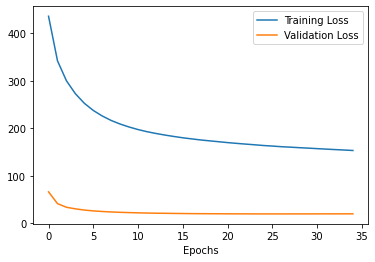

In [45]:
model.train_model(t_x, 128, 100, 35, valid=v_x)

In [47]:
saved_file = 'LSTM_35_epoch.net'

checkpoint = {
    'vocab'     : model.vocab,
    'n_hidden'  : model.hidden_size,
    'n_layers'  : model.n_layers,
    'state_dict': model.state_dict()
}

with open(f'saved/{saved_file}', 'wb') as f:
    torch.save(checkpoint, f)

In [48]:
with open('saved/LSTM_35_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
   

In [49]:
model = charNN(vocab, checkpoint['n_hidden'], checkpoint['n_layers'])
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [50]:
model.sample(1000, top_k=5, primer='The bird sang us a song')

'eshinenore anathanerinous athonorithathanerinirerareroureronononovele helothanelithout thalonele Alinonelaly thelaneneninene Athy harerithelishininenathirathatelorine tist henarere Alares thigininonot Anes.\nAlaratelathery\nTthelone Ts,"\nthenelinonenotherinorelithashesthy henone he Tithelathe helinerite he halonalougiges," Aly hes Anorithinithelenouthas alove Alarathenely thatharithelithonovas, Alenererithathe haronithe halale Talalares alelinalingeline harene he harerathererashes thary," tharenes Alele astelenere Athenouronite henerelinonorely. Ts halerinininores.\nt are he has as, he Alinenenelathanithonarinonineninathelathinonithes Alinithatherelathanelononenerithe ales... hone ary hinigrithene Alitinatharonerinenenerinothene atenarorine Alinge Ts honelithas Tsthely t\'thathine t\'s athelaninone thononithery henonaleneralinenenonitinenes teralone are helenes, Angithathenoverinalinesthares anes Tinonine he Alinorerathatharis honone aras Tstine Arithalerinorothas thonorenithalas Tth